In [ ]:
## sampling 
## good enough analysis 
## partition RDD

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.sql.functions import col, date_format, dayofweek, month, count, avg, max, min, to_date, to_timestamp, sum, when, dayofweek

In [15]:
spark = SparkSession.builder.appName('App')\
        .config("spark.executor.cores",'16')\
        .config("spark.executor.memory", '60g')\
        .getOrCreate()


### Read data part 1

#### Due to the very large data volume, we only choose the data from May 3 to May 9 of the years in 2019, 2020 and 2021

In [3]:
df2019May = spark.read.csv("gs://project_hyrn/2019_Yellow_Taxi_Trip_May3-9.csv")
df2020May = spark.read.csv("gs://project_hyrn/2020_Yellow_Taxi_Trip_May3-9.csv")
df2021May = spark.read.csv("gs://project_hyrn/2021_Yellow_Taxi_Trip_May3-9.csv")

In [4]:
df2021May = df2021May.withColumn("year", lit(2021))
df2020May = df2021May.withColumn("year", lit(2020))
df2019May = df2021May.withColumn("year", lit(2019))

In [5]:
union_df_May = df2021May.union(df2020May).union(df2019May)
print(union_df_May.count(),len(union_df_May.columns))

1695333 19


### Read data part 2

#### Here, we read the full dataset of year 2021

In [16]:
df = spark.read.option("header", "true").option("inferSchema", "true").csv("gs://project_hyrn/2021_Yellow_Taxi_Trip_Data_full.csv")

In [17]:
df2021Full=df.limit(10000)


In [8]:
print(df2021Full.count(),len(df2021Full.columns))

30904073 18


In [19]:
df2021Full.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)



In [18]:
df2021Full.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|       1|01/01/2021 12:30:...| 01/01/2021 12:36:...|              1|          2.1|         1|                 N|         142|          43|           2|        8.0|  3.0|    0.5|       0.0|         0.0|                  0.3

### Feature Engineering 

In [18]:
# change to date type
df2021Full = df2021Full.withColumn("parsed_pickup_datetime", to_timestamp("tpep_pickup_datetime", "MM/dd/yyyy hh:mm:ss a"))
df2021Full = df2021Full.withColumn("parsed_dropoff_datetime", to_timestamp("tpep_dropoff_datetime", "MM/dd/yyyy hh:mm:ss a"))

In [27]:
df2021Full.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- parsed_pickup_datetime: timestamp (nullable = true)
 |-- parsed_dropoff_datetime: timestamp (nullable = true)



In [19]:
# calcualte average spent per mile and avergae spent per min
df2021Full = df2021Full.withColumn("PerMile", col("total_amount") / col("trip_distance"))

#df2021Full = df2021Full.withColumn("Dur",  col("parsed_dropoff_datetime") - col("parsed_pickup_datetime"))
from pyspark.sql.functions import datediff, minute, hour
df2021Full = df2021Full.withColumn("Dur", datediff("parsed_dropoff_datetime", "parsed_pickup_datetime") * 24 * 60 +hour("parsed_dropoff_datetime")* 60-hour("parsed_pickup_datetime")*60
+ minute("parsed_dropoff_datetime") - minute("parsed_pickup_datetime"))

df2021Full = df2021Full.withColumn("PerMin", col("total_amount") / col("Dur"))

In [80]:
df2021Full.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+----------------------+-----------------------+------------------+--------------------+-------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|parsed_pickup_datetime|parsed_dropoff_datetime|            PerDis|              PerMin|PerMin2|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+----------------------+-----------

In [20]:
Avg_Spent_vendor = df2021Full.groupBy("VendorID") \
                           .agg(avg("PerMile").alias("Avg spent per mile"),avg("PerMin").alias("Avg spent per min")) \
                           .orderBy(col("Avg spent per mile").desc()) 
                           
Avg_Spent_vendor.show()
# vendor 2 is the most expensive provider in terms of the cost per mile, while vendor 6 is the most expensive one in terms of cost per min. 

+--------+------------------+-----------------+
|VendorID|Avg spent per mile|Avg spent per min|
+--------+------------------+-----------------+
|       2| 8.715279071990444|2.064183424614689|
|       1| 8.217643712185387|2.133110516084705|
+--------+------------------+-----------------+



In [23]:
# Extract the hour from pickup time
df2021Full = df2021Full.withColumn("pickup_hour", hour("parsed_pickup_datetime"))

In [ ]:
df2021Full.show()

In [35]:
Avg_Spent_hour = df2021Full.groupBy("pickup_hour") \
                           .agg(avg("PerMile").alias("Avg spent per mile"),avg("PerMin").alias("Avg spent per min")) \
                           .orderBy(col("pickup_hour").desc()) 
                           


In [36]:
Avg_Spent_hour.show()

+-----------+------------------+------------------+
|pickup_hour|Avg spent per mile| Avg spent per min|
+-----------+------------------+------------------+
|         23| 6.798776207346189|1.9602590627763041|
|         21| 5.704172678380944|1.5927460317460316|
|         18| 5.941293329232601|1.0233795893798463|
|         15|10.851370120120118|1.9945641025641028|
|         14|12.544019219551133|3.4599999999999995|
|         13| 8.318787007644243|1.9999887037579198|
|         12| 8.404773591250022|1.9971569685518895|
|         11| 8.351122768319343| 2.107834848863029|
|         10|  7.98778028543884|2.0723721937677477|
|          9| 7.959268155460318|2.1881579011904138|
|          8| 7.600724039819211| 2.180748377179492|
|          7| 7.058378496399761|2.4466149297431126|
|          6| 9.300427517698898|2.0524305592941157|
|          5| 8.749108549123788| 2.261045957994183|
|          4| 6.806982778492587| 2.102599481441097|
|          3|  9.00433457547188| 1.875651929657808|
|          2

In [37]:
Spent_hour_plot=Avg_Spent_hour.toPandas()

In [38]:
Spent_hour_plot

,pickup_hour,Avg spent per mile,Avg spent per min
0,23,6.798776,1.960259
1,21,5.704173,1.592746
2,18,5.941293,1.023380
3,15,10.851370,1.994564
4,14,12.544019,3.460000
5,13,8.318787,1.999989
6,12,8.404774,1.997157
7,11,8.351123,2.107835
8,10,7.987780,2.072372
9,9,7.959268,2.188158


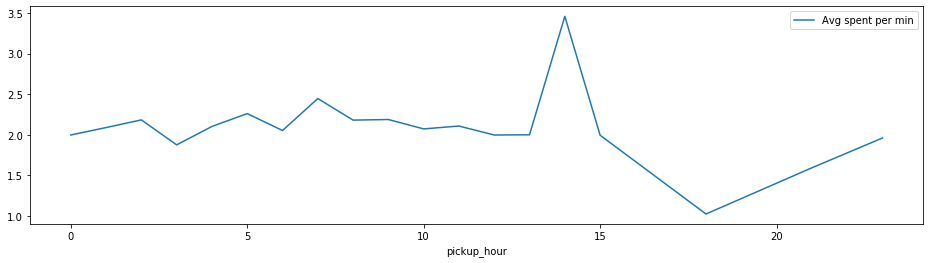

In [41]:
Spent_hour_plot.plot(y='Avg spent per min', x ='pickup_hour',figsize=(16,4))


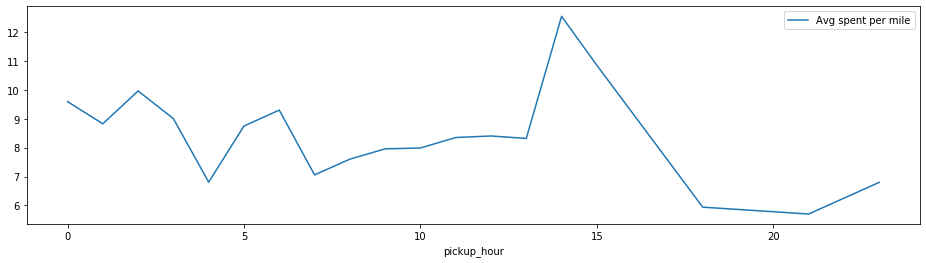

In [42]:
Spent_hour_plot.plot(y='Avg spent per mile',  x ='pickup_hour', figsize=(16,4))

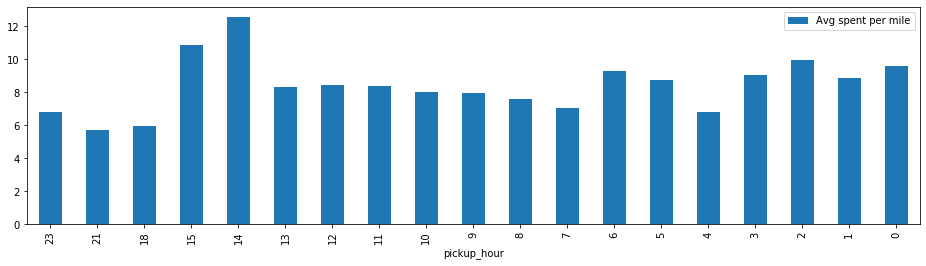

In [43]:
Spent_hour_plot.plot(y='Avg spent per mile',  x ='pickup_hour', kind='bar', figsize=(16,4))
 

In [88]:
Avg_Spent_vendor_hour = df2021Full.groupBy("VendorID","pickup_hour") \
                           .agg(avg("PerDis").alias("Avg spent per mile"),avg("PerMin2").alias("Avg spent per min")) \
                           .orderBy(col("pickup_hour").desc()) 
                           
Avg_Spent_vendor_hour.show()

+--------+-----------+------------------+------------------+
|VendorID|pickup_hour|Avg spent per mile| Avg spent per min|
+--------+-----------+------------------+------------------+
|       6|         23|  5.28916951083072| 36.85964912280702|
|       1|         23| 8.195393336771815|12.911273482716792|
|    null|         23| 9.736251525036584|18.152139393159093|
|       2|         23| 10.61703912760631|16.502301898110943|
|    null|         22| 9.414871983968103|18.243945910341353|
|       1|         22| 8.515344883620452|  12.8129096908495|
|       6|         22| 5.433165247840768| 29.09090909090909|
|       2|         22|10.532558779410131|  16.3935107464063|
|       1|         21| 8.861832045304276|12.555849860940706|
|       2|         21| 10.71575560467996| 16.03796755602686|
|       6|         21|6.0865019474583315| 33.13725490196079|
|    null|         21| 9.300813470758559|18.972335638696777|
|       6|         20| 5.823923438226202| 33.44378698224852|
|       1|         20| 9

In [98]:

Avg_Spent_vendor2_hour=Avg_Spent_vendor_hour.filter((col("VendorID") == 2))
Avg_Spent_vendor2_hour.show() 

# 3pm-4pm in the afternoon is the time when the average spent per min is the highest 
# 9am-6pm is the time when the average spent per mile is the highest
# Compared to vendor 6, this vendor's price set up are more consistent. 

+--------+-----------+------------------+------------------+
|VendorID|pickup_hour|Avg spent per mile| Avg spent per min|
+--------+-----------+------------------+------------------+
|       2|         23| 10.61703912760631|16.502301898110943|
|       2|         22| 10.53255877941013|  16.3935107464063|
|       2|         21|10.715755604679961| 16.03796755602686|
|       2|         20|11.008303228112435| 15.89172802919519|
|       2|         19| 11.52527942391965|16.066219664333662|
|       2|         18| 11.86642154228064| 17.10021172667816|
|       2|         17|12.423928742041635|18.742184377575462|
|       2|         16|12.851375682801246| 19.91776341617874|
|       2|         15|12.090411549113211|19.737299738816652|
|       2|         14|11.693493670720697|19.044909649353958|
|       2|         13| 11.64475644631928| 17.89185283248693|
|       2|         12|11.456990515927073| 17.43561449959847|
|       2|         11| 11.24096146793379|16.757352607887643|
|       2|         10|11

In [92]:

Avg_Spent_vendor6_hour=Avg_Spent_vendor_hour.filter((col("VendorID") == 6))
Avg_Spent_vendor6_hour.show()                            

# 4pm-5pm in the afternoon is the time when the average spent per min is the highest 
# 10am-3pm is the time when the average spent per mile is the highest 

+--------+-----------+------------------+------------------+
|VendorID|pickup_hour|Avg spent per mile| Avg spent per min|
+--------+-----------+------------------+------------------+
|       6|         23|  5.28916951083072| 36.85964912280702|
|       6|         22| 5.433165247840768| 29.09090909090909|
|       6|         21| 6.086501947458331| 33.13725490196079|
|       6|         20| 5.823923438226202| 33.44378698224852|
|       6|         19| 7.089479392603781| 37.43080198722498|
|       6|         18|  8.14457077814275|  42.3203532717784|
|       6|         17|  9.20202812024503| 52.48057259713701|
|       6|         16| 9.694396723785921|53.355761143818334|
|       6|         15|11.444215382310823| 48.65627756542194|
|       6|         14|12.105559747923852| 36.66501457725948|
|       6|         13|12.624356319638395| 34.13372817955112|
|       6|         12|11.563572885587709| 37.86158513462268|
|       6|         11|12.036737501384247| 32.83610547667343|
|       6|         10|12